In [71]:
%pylab notebook

import pandas as pd
import numpy as np
from datetime import datetime
import lightgbm as gbm

Populating the interactive namespace from numpy and matplotlib


/Users/karper/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [72]:
def score(Y_pred, Y_true):
    E = np.sqrt(np.sum((Y_pred - Y_true)**2))
    L2pred = np.sqrt(np.sum(Y_pred**2))
    L2true = np.sqrt(np.sum(Y_true**2))
    
    return 2*E/(L2pred + L2true)
    

In [166]:
class LGBMForecaster():
    
    def __init__(self, input_tags, output_tags, window_size):
        self.input_tags  = input_tags
        self.output_tags = output_tags
        self.window_size = window_size
        
        self.estimator = {}
        for var in output_tags:
            self.estimator[var] = gbm.LGBMRegressor(n_estimators=40)

                
    def fit(self,data):
        TT = pd.to_datetime(data.timestamp, unit='ms').values
        print('Training on ', TT[0], TT[-1])
        X = data[self.input_tags].values
        for var in self.output_tags:
            y = data[var]
            self.estimator[var].fit(X, y)
            
        self.training_data = data
        
    def predict(self,data):
        T = data.timestamp.values
        DT = T[-1]-T[0]
        if(DT>self.window_size):
            dt_pred = np.arange(T[0], T[-1], self.window_size)
        else:
            dt_pred=[T[0]]


        Ypred = pd.DataFrame(columns=self.output_tags)
        
        for i in range(0, len(dt_pred)):
            t = dt_pred[i]
            try:
                t_next = np.minimum(T[-1], t+self.window_size)
                t_condition = (data.timestamp >= t) & (data.timestamp < t_next)
                data_t = data[t_condition]
                Xpred  = data_t[self.input_tags].values
            
                Ypred_this = pd.DataFrame()
                Ypred_this['timestamp'] = data_t.timestamp
                for var in self.output_tags:
                    Ypred_this[var] = self.estimator[var].predict(Xpred)
            
                Ypred = pd.concat([Ypred, Ypred_this])
            
                if(t_next==t+self.window_size):
                    training_data = pd.concat([self.training_data, data_t])
                    self.fit(training_data)
                
            except:
                pass
            
        return Ypred
                
            
        
        
        
    
    
    
    
    
    
    
    
    
    

In [167]:
data = pd.read_csv('../virtual_metering/d2_train.csv')

In [168]:
data = data.drop(['SKAP_18SCSSV3205/BCH/10sSAMP|average', 'SKAP_18HPB320/BCH/10sSAMP|average'], axis=1)

In [169]:
time_cond = (data.timestamp > int(datetime(2014, 3, 1).timestamp()*1000))
data = data[time_cond]

In [170]:
output_columns = ['SKAP_18FI381-VFlLGas/Y/10sSAMP|average',
                  'SKAP_18FI381-VFlLH2O/Y/10sSAMP|average',
                  'SKAP_18FI381-VFlLOil/Y/10sSAMP|average']

output_data = data[output_columns]
input_data  = data.drop(output_columns, axis=1)
input_data  = input_data.drop(['timestamp','Unnamed: 0'], axis=1)
input_columns = list(input_data.columns.values)
T = data.timestamp

In [171]:
rcond = (data.index < len(data)*0.7)
data_train = data[rcond]
data_test = data[~rcond]

In [172]:
wsize = int(1000*60*60*24*14)
reg = LGBMForecaster(input_columns, output_columns, wsize)
reg.fit(data_train)

Training on  2014-02-28T23:10:00.000000000 2016-01-19T01:20:00.000000000


In [ ]:
Y_pred = reg.predict(data_test)

Training on  2014-02-28T23:10:00.000000000 2016-02-02T01:20:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-02-16T01:20:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-03-01T01:20:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-03-15T01:20:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-03-29T01:20:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-04-12T01:20:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-04-26T01:20:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-05-10T01:20:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-05-23T21:40:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-06-07T01:20:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-06-20T22:50:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-07-03T20:10:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-07-19T01:20:00.000000000
Training on  2014-02-28T23:10:00.000000000 2016-08-

In [165]:
Y_test = data_test[output_columns]
for var in output_columns:
    print(var, score(Y_pred[var], Y_test[var]))

SKAP_18FI381-VFlLGas/Y/10sSAMP|average 0.0951594704004259
SKAP_18FI381-VFlLH2O/Y/10sSAMP|average 0.2277431474991691
SKAP_18FI381-VFlLOil/Y/10sSAMP|average 0.24342215596472852


<IPython.core.display.Javascript object>


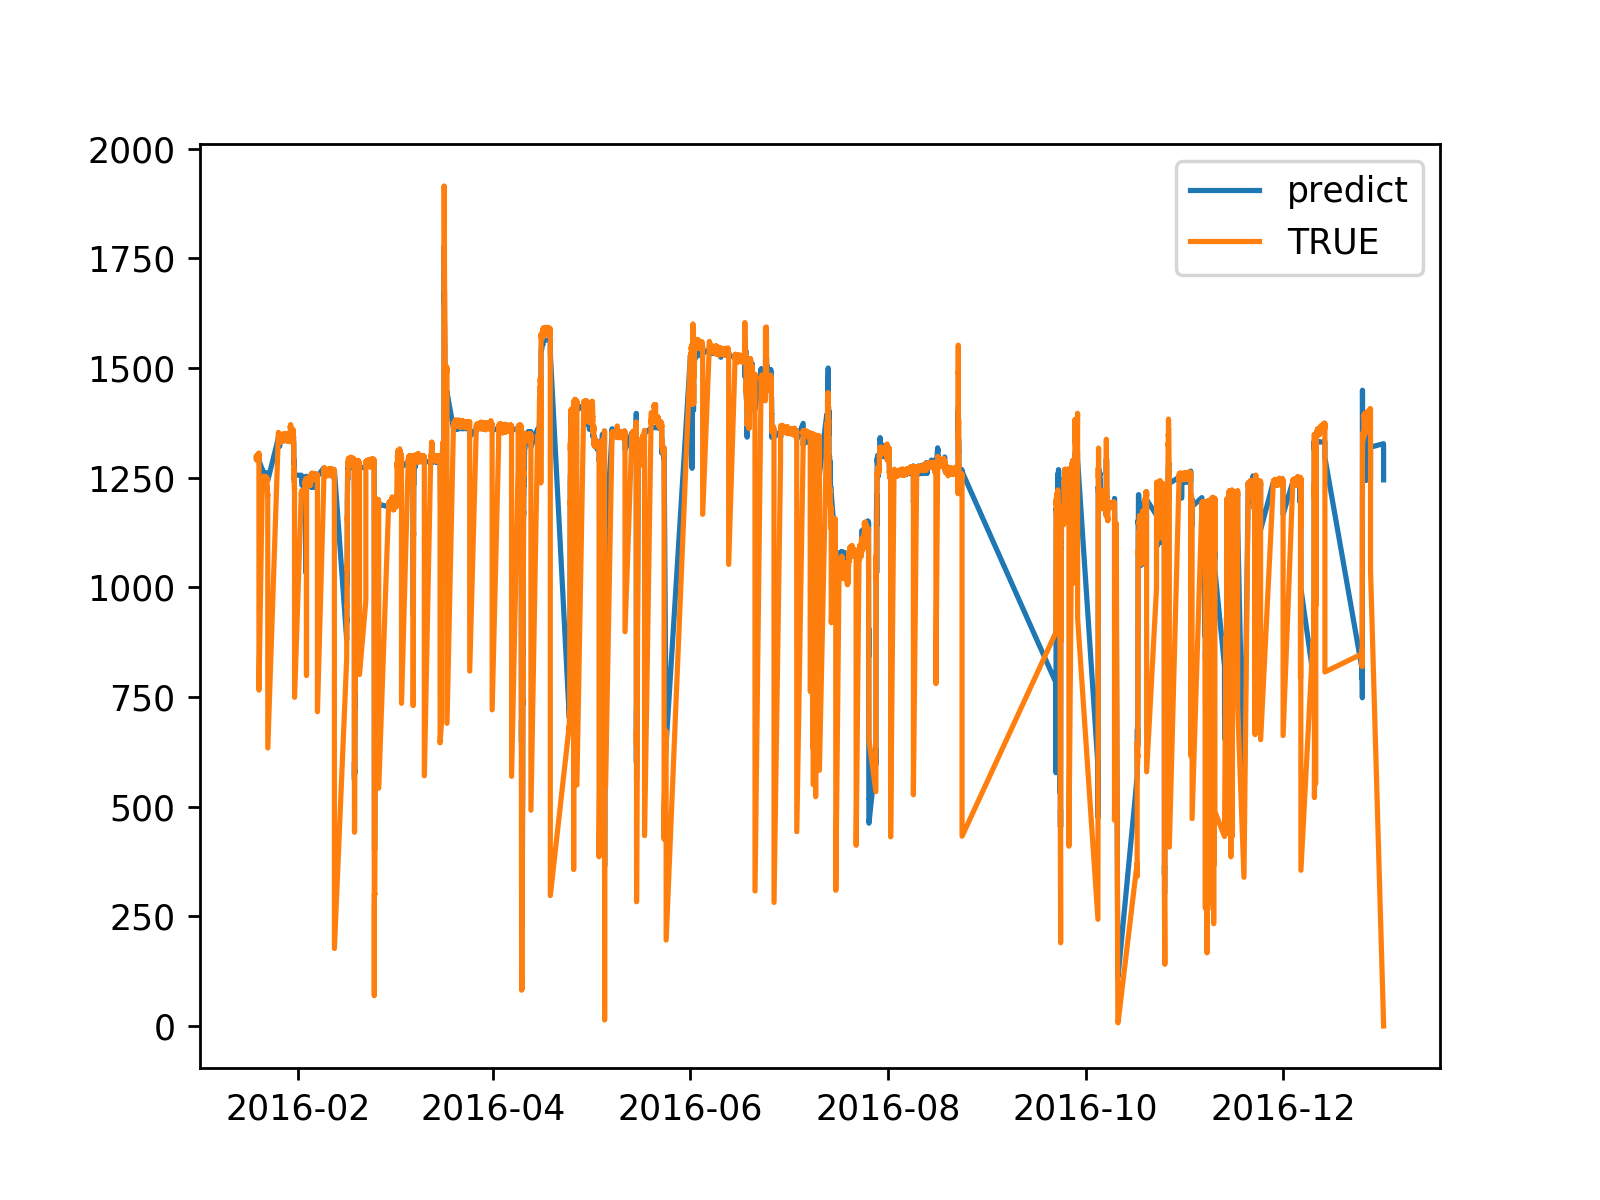

<IPython.core.display.Javascript object>


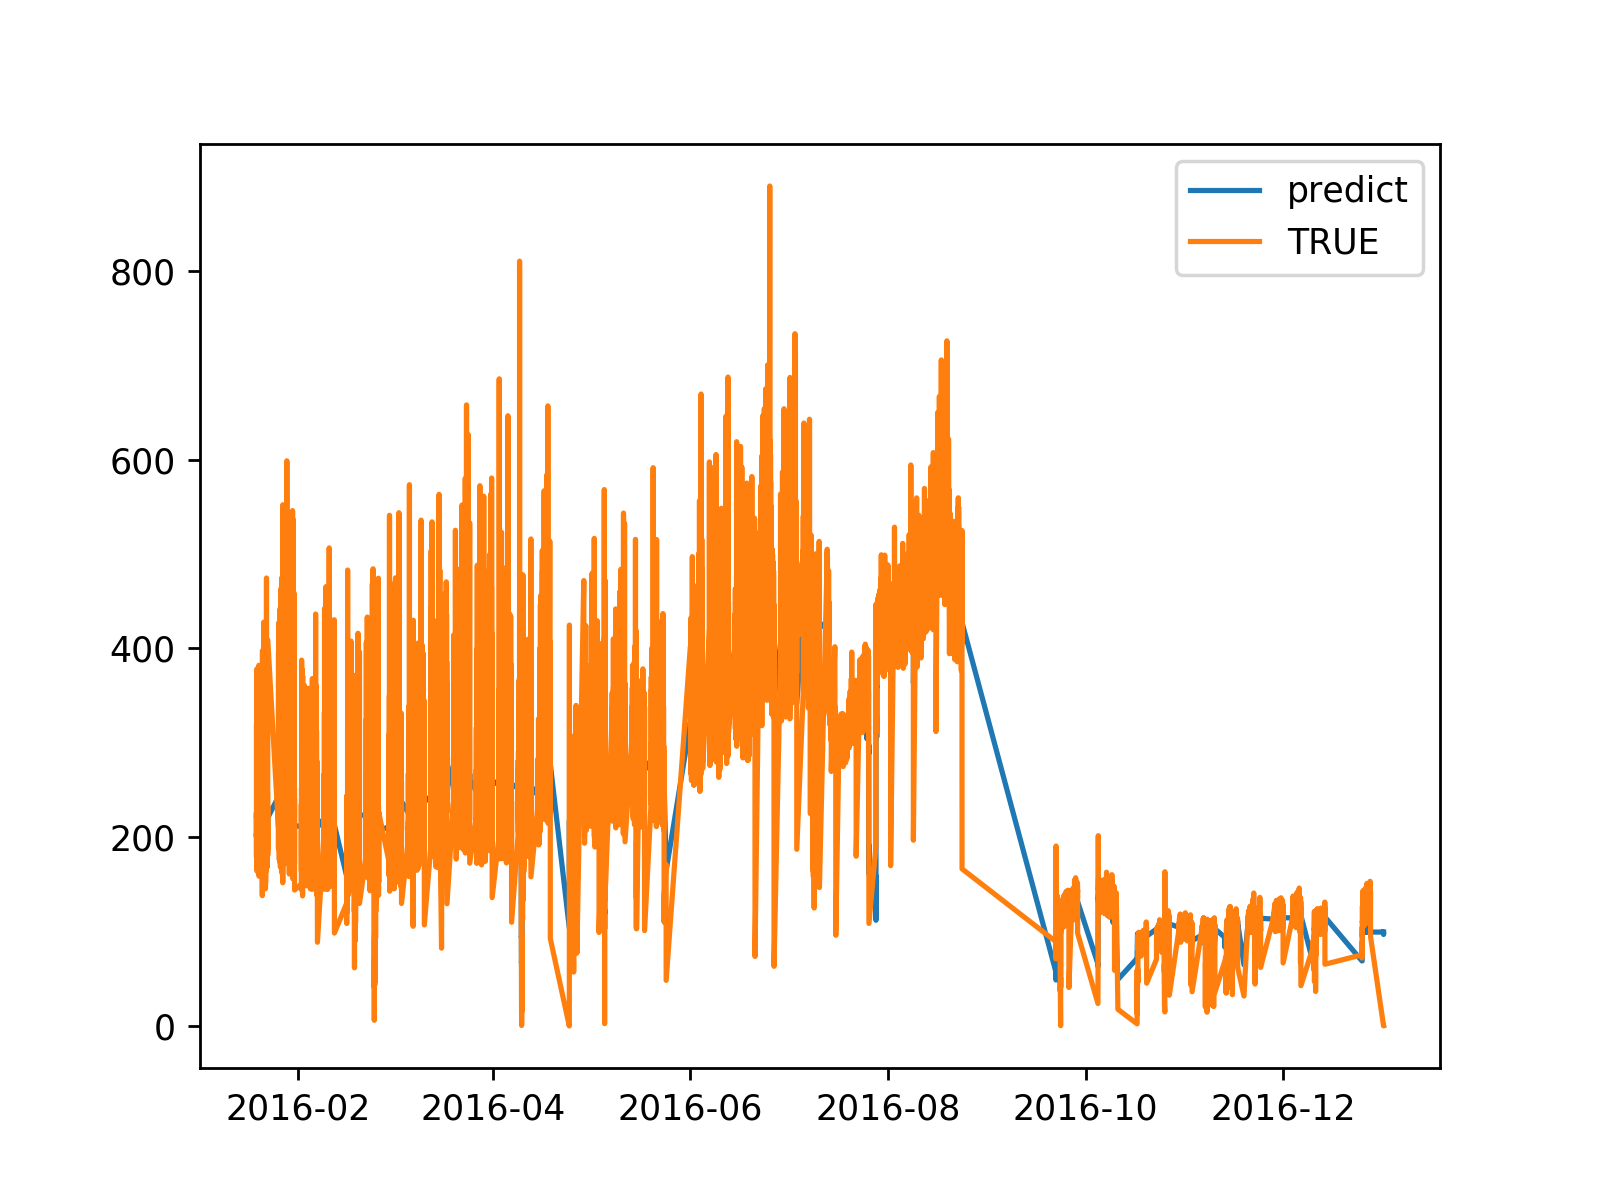

<IPython.core.display.Javascript object>


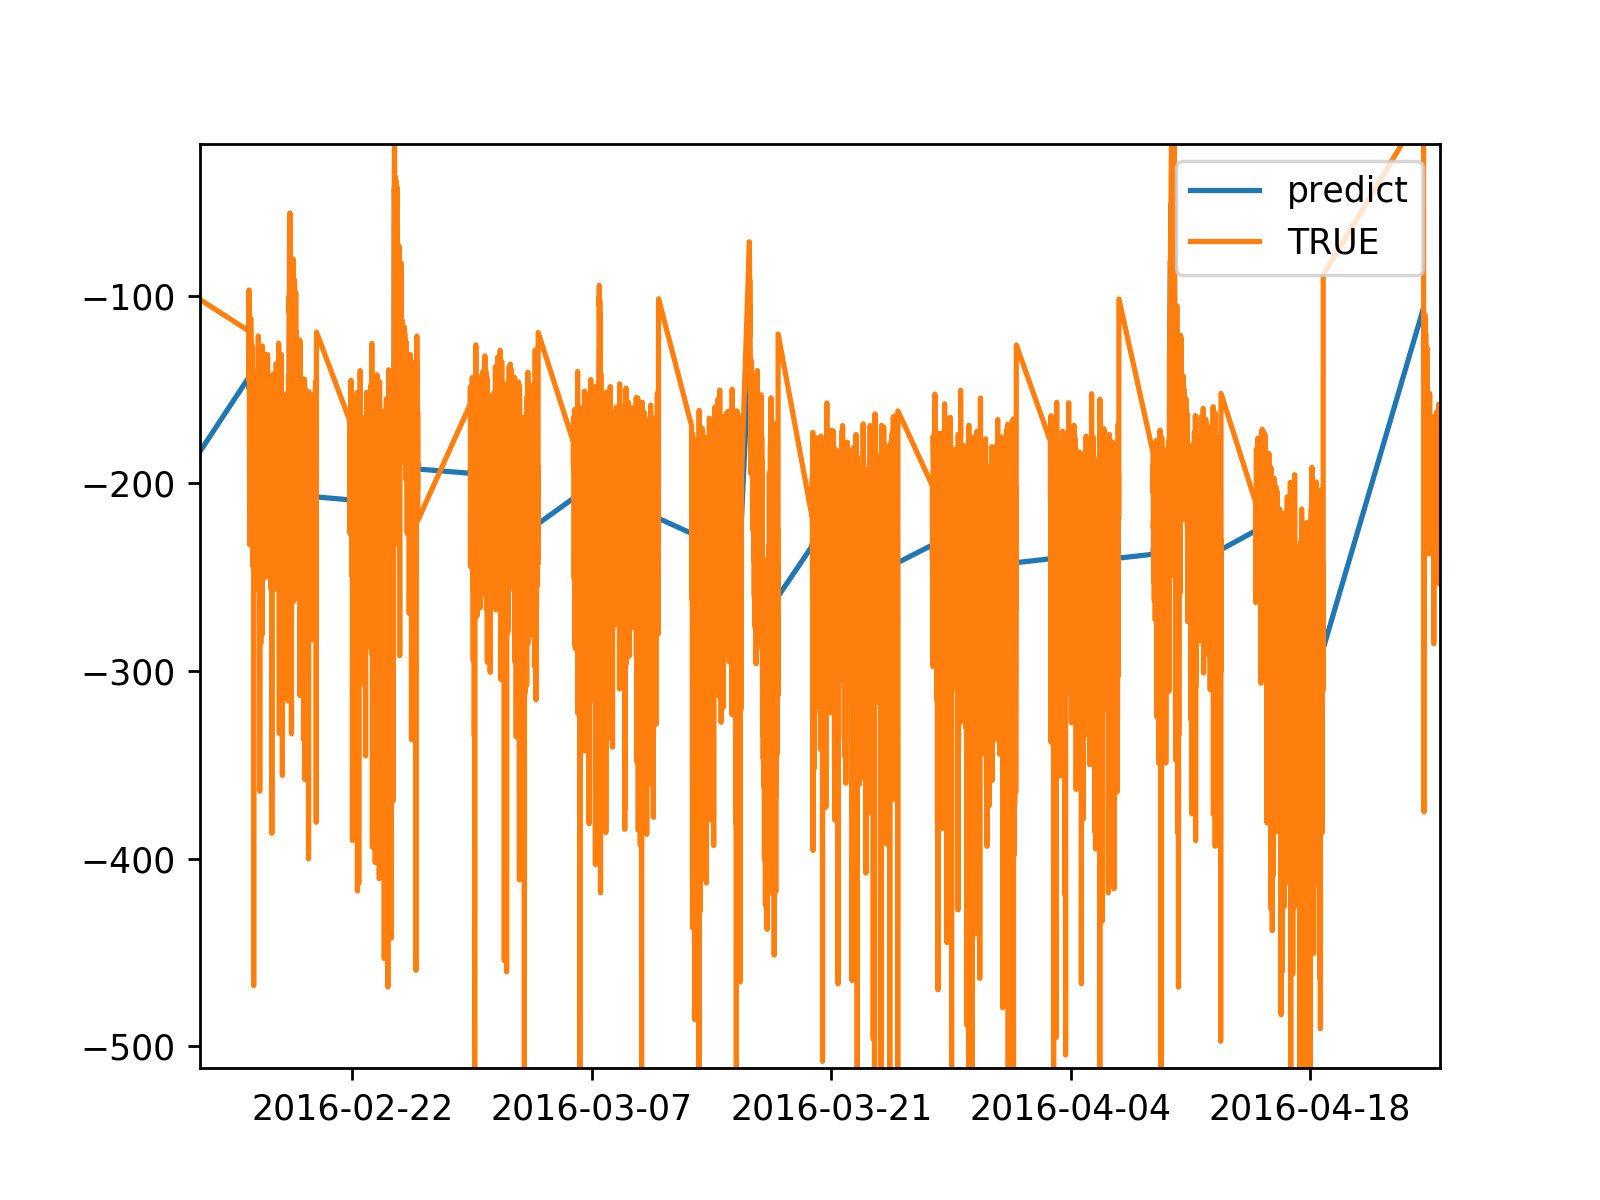

In [156]:
T_pred = pd.to_datetime(Y_pred.timestamp, unit='ms')
T_test = pd.to_datetime(data_test.timestamp, unit='ms')



for var in output_columns:
    plt.figure()
    plt.plot(T_pred, Y_pred[var], label='predict')
    plt.plot(T_test, Y_test[var], label='TRUE')
    plt.legend()

In [39]:
var_list = X_test.columns
importance = lgbm.feature_importances_

In [41]:
imp = pd.DataFrame()
imp['Name'] = var_list
imp['Ranking'] = importance

In [45]:
imp.sort_values(by='Ranking')

,Name,Ranking
3,SKAP_18HV3806/BCH/10sSAMP|stepinterpolation,0
14,SKAP_18ESV3213/BCH/10sSamp|stepinterpolation,0
19,SKAP_18ESV3220/BCH/10sSamp|stepinterpolation,0
12,SKAP_18ESV3207/BCH/10sSamp|stepinterpolation,0
11,SKAP_18ESV3206/BCH/10sSamp|stepinterpolation,0
15,SKAP_18ESV3214/BCH/10sSAMP|stepinterpolation,6
16,SKAP_18ESV3215/BCH/10sSamp|stepinterpolation,9
13,SKAP_18ESV3211/BCH/10sSAMP|stepinterpolation,12
18,SKAP_18ESV3219/BCH/10sSamp|stepinterpolation,14
17,SKAP_18ESV3218/BCH/10sSamp|stepinterpolation,34
